In [5]:
%matplotlib inline
import sys
sys.path.append('/Users/mehdi/Dropbox/github/DESILSS')
import numpy as np
import matplotlib.pyplot as plt

In [3]:
file = "/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel_f8/fold0/reg-nepoch2000-nchain5-batchsize200units33-Lrate0.001.npz"

In [6]:
d     = np.load(file)
out   = d['arr_0'].item()
#
hpix  = out['test'][0]
#
meanY = np.mean(out['train'][2])
stdY  = np.std(out['train'][2])
#
Xtrue = out['test'][1]
Ytrue = (out['test'][2].squeeze() - meanY) / stdY
#
y_avg = []
for i in range(len(out['chain_y'])):
    y_avg.append(out['chain_y'][i][1].squeeze().tolist())    
Ypred = np.mean(np.array(y_avg), axis=0)

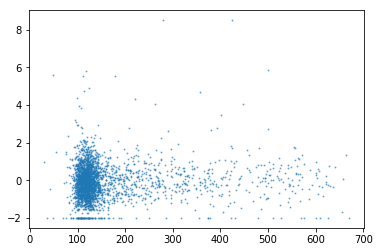

In [7]:
plt.scatter(Xtrue, Ytrue, 1., alpha=0.5)

In [ ]:
help(np.)

In [9]:
from scipy.stats import binned_statistic as bs

In [6]:
Xtrue.shape

(2688, 1)

In [10]:
y,b1,_ = bs(Xtrue.squeeze(), Ytrue, bins=np.logspace(1.8, 3, 16))
ye,b2,_ = bs(Xtrue.squeeze(), Ytrue, statistic=np.std,bins=np.logspace(1.8, 3, 16))

Text(0,0.5,'scaled label')

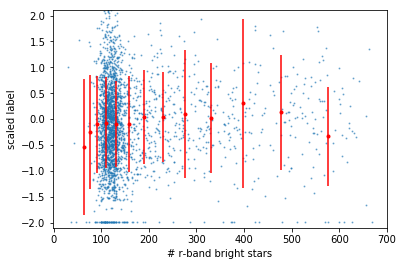

In [12]:
plt.scatter(Xtrue, Ytrue, 1., alpha=0.5)
plt.errorbar(b1[:-1], y, ye , ls="None", marker='.', color='r')
plt.ylim(-2.1, 2.1)
plt.xlabel("# r-band bright stars")
plt.ylabel("scaled label")
#plt.text(100, 8, "fold-0")

In [6]:
help(bs)

Help on function binned_statistic in module scipy.stats._binned_statistic:

binned_statistic(x, values, statistic='mean', bins=10, range=None)
    Compute a binned statistic for one or more sets of data.
    
    This is a generalization of a histogram function.  A histogram divides
    the space into bins, and returns the count of the number of points in
    each bin.  This function allows the computation of the sum, mean, median,
    or other statistic of the values (or set of values) within each bin.
    
    Parameters
    ----------
    x : (N,) array_like
        A sequence of values to be binned.
    values : (N,) array_like or list of (N,) array_like
        The data on which the statistic will be computed.  This must be
        the same shape as `x`, or a set of sequences - each the same shape as
        `x`.  If `values` is a set of sequences, the statistic will be computed
        on each independently.
    statistic : string or callable, optional
        The statistic to co

In [5]:
#
from scipy.optimize import minimize

In [6]:
def lin(theta, x, *args):
    return theta[0] + theta[1] * x
def poly(theta, x, *args):
    return theta[0] + theta[1] * x + theta[2] * x * x

class sysfit(object):
    def __init__(self,x,y,ye, mask=None):
        if mask is None:
            mask = np.ones(x.size, '?')
        self.org = (x,y,ye)
        self.x  = x[mask]
        self.y  = y[mask]
        self.ye = ye[mask]
        self.mask = mask
        
    def chi2lin(self, theta,  *args):
        return np.mean( ((lin(theta, self.x) - self.y)/(self.ye))**2)

    def chi2poly(self, theta,  *args):
        return np.mean( ((poly(theta, self.x) - self.y)/(self.ye))**2)
        
    def Minimize(self, theta0, fit='lin'):
        if fit == 'lin':
            self.res = minimize(self.chi2lin, theta0)
        elif fit == 'poly':
            self.res = minimize(self.chi2poly, theta0)
        self.theta = self.res.x

In [7]:
Ytrue.shape

(2688,)

In [8]:
ngal_rbs = sysfit(Xtrue, Ytrue, np.ones(Ytrue.shape))

In [9]:
ngal_rbs.Minimize([0, 0.01], fit='lin')
thetalin = np.copy(ngal_rbs.theta)

In [10]:
ngal_rbs.Minimize([0, 0.1, 0.1], fit='poly')
thetapol = np.copy(ngal_rbs.theta)

In [11]:
thetapol, thetalin

(array([-6.95121228e-02,  1.22994914e-04, -2.04989599e-07]),
 array([-5.70946465e-02, -2.47545446e-08]))

In [13]:
get_rmse = lambda a : np.sqrt(np.mean((a - Ytrue)**2))

2688


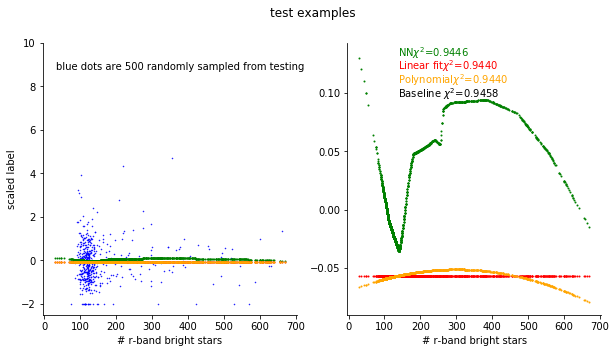

In [17]:
print(Xtrue.size)
plt.rc('axes.spines', right=False, top=False)
arg = np.random.choice(np.arange(Xtrue.size), replace=False, size=500)
f, a = plt.subplots(ncols=2, figsize=(10, 5))
plt.suptitle("test examples")
a[0].scatter(Xtrue[arg], Ytrue[arg], 1, color='b', marker='.')
a[0].scatter(Xtrue, Ypred, 1., color='g')
a[0].scatter(Xtrue, lin(thetalin, Xtrue), 1., 'r')
a[0].scatter(Xtrue, poly(thetapol, Xtrue), 1., 'orange')
a[1].scatter(Xtrue, Ypred, 1., color='g')
a[1].scatter(Xtrue, lin(thetalin, Xtrue), 1., 'r')
a[1].scatter(Xtrue, poly(thetapol, Xtrue), 1., 'orange')
a[0].set_ylim(-2.5, 10)
l = ['NN', 'Linear fit', 'Polynomial']
c = ['g', 'r', 'orange']
chi = list(map(get_rmse, [Ypred, lin(thetalin, Xtrue), poly(thetapol, Xtrue)]))
for i in range(3):
    a[1].text(0.2, 0.95-i*0.05, l[i]+'$\chi^{}$={:.4f}'.format(2, chi[i]), color=c[i], transform=a[1].transAxes)
a[1].text(0.2, 0.95-.15, r'Baseline $\chi^{}$={:.4f}'.format(2, get_rmse(0.0)), color='k', transform=a[1].transAxes)
a[0].set_ylabel("scaled label")
a[0].text(0.05, 0.9, "blue dots are 500 randomly sampled from testing", fontsize=10, transform=a[0].transAxes)
for a_i in a:a_i.set_xlabel("# r-band bright stars")
plt.savefig("./lin_NN_poly.pdf", bbox_inches="tight")

In [15]:
print("RMSE NN : {:.4f}, Linfit : {:.6f}, Polyfit : {:.6f}, Baseline : {:.4f}"\
      .format(*list(map(get_rmse, [Ypred, lin(thetalin, Xtrue), poly(thetapol, Xtrue), 0.0]))))

RMSE NN : 0.9446, Linfit : 0.944033, Polyfit : 0.944038, Baseline : 0.9458


In [76]:
meanY

9.86498445256653

In [18]:
from scipy.stats import pearsonr as pearsonr

In [19]:
pearsonr(Xtrue.squeeze(), Ytrue)

(0.04692024937097586, 0.014981243877316275)

In [20]:
Xtrue.squeeze()

array([124.,  76., 112., ..., 114., 116., 100.])